In [21]:
import os
import numpy as np
import pandas as pd
import dataframe_image as dfi
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import shap

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
pd.set_option('display.max_columns', None)

In [22]:
master_table = pd.read_csv (r"/Users/stephenak24/Downloads/master_table.txt")
master_table.to_csv (r"/Users/stephenak24/Downloads/master_table.csv", index=None)

In [23]:
master_table

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,year,team,W,W/L%,seed,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player
0,1,Kareem Abdul-Jabbar,32,LAL,147.0,147.0,221,0.665,82,38.3,24.8,10.8,4.5,1.0,3.4,0.604,0.000,0.765,14.8,0.227,1980,Los Angeles Lakers,60.0,0.732,1.0,25.3,0.639,0.001,0.344,7.2,22.2,15.4,16.5,1.2,4.6,15.7,24.1,9.5,5.3,14.8,0.227,4.8,2.4,7.2,7.3
1,2,Julius Erving,29,PHI,31.5,31.5,221,0.143,78,36.1,26.9,7.4,4.6,2.2,1.8,0.519,0.200,0.787,12.5,0.213,1980,Philadelphia 76ers,59.0,0.720,2.0,25.4,0.568,0.012,0.331,8.6,12.9,10.9,21.4,2.8,2.7,13.3,30.3,7.3,5.2,12.5,0.213,5.7,1.9,7.6,6.8
2,3,George Gervin,27,SAS,19.0,19.0,221,0.086,78,37.6,33.1,5.2,2.6,1.4,1.0,0.528,0.314,0.852,10.6,0.173,1980,San Antonio Spurs,41.0,0.500,4.5,24.0,0.587,0.053,0.306,5.7,8.9,7.3,11.0,1.6,1.4,10.3,31.7,9.3,1.3,10.6,0.173,5.5,-1.6,3.9,4.4
3,4,Larry Bird,23,BOS,15.0,15.0,221,0.068,82,36.0,21.3,10.4,4.5,1.7,0.6,0.474,0.406,0.836,11.2,0.182,1980,Boston Celtics,61.0,0.744,1.0,20.5,0.538,0.098,0.246,8.3,23.6,16.0,18.5,2.3,1.0,14.0,25.3,5.6,5.6,11.2,0.182,3.0,1.5,4.5,4.8
4,5T,Tiny Archibald,31,BOS,2.0,2.0,221,0.009,80,35.8,14.1,2.5,8.4,1.3,0.1,0.482,0.222,0.830,8.9,0.148,1980,Boston Celtics,61.0,0.744,1.0,15.3,0.574,0.023,0.548,2.3,5.3,3.8,30.2,1.7,0.2,19.7,17.0,5.9,2.9,8.9,0.148,1.4,-0.3,1.1,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,10,Rudy Gobert,28,UTA,0.0,8.0,1010,0.008,71,30.8,14.3,13.5,1.3,0.6,2.7,0.675,0.000,0.623,11.3,0.248,2021,Utah Jazz,52.0,0.722,1.0,23.5,0.683,0.007,0.646,12.2,33.5,23.3,6.0,0.9,7.0,13.7,17.0,6.1,5.2,11.3,0.248,2.1,2.8,4.9,3.8
675,11,Russell Westbrook,32,WAS,0.0,5.0,1010,0.005,65,36.4,22.2,11.5,11.7,1.4,0.4,0.439,0.315,0.656,3.7,0.075,2021,Washington Wizards,34.0,0.472,8.5,19.5,0.509,0.221,0.334,4.9,28.6,16.8,48.6,1.7,0.8,18.0,30.2,0.5,3.2,3.7,0.075,2.6,1.1,3.7,3.4
676,12,Ben Simmons,24,PHI,0.0,3.0,1010,0.003,58,32.4,14.3,7.2,6.9,1.6,0.6,0.557,0.300,0.613,6.0,0.153,2021,Philadelphia 76ers,49.0,0.681,1.0,18.3,0.584,0.017,0.492,5.6,18.7,12.2,31.3,2.4,1.7,19.6,20.2,2.7,3.3,6.0,0.153,0.7,2.2,2.9,2.3
677,13T,LeBron James,36,LAL,0.0,1.0,1010,0.001,45,33.4,25.0,7.7,7.8,1.1,0.6,0.513,0.365,0.698,5.6,0.179,2021,Los Angeles Lakers,42.0,0.583,6.0,24.2,0.602,0.346,0.310,2.2,23.6,12.9,41.8,1.6,1.5,15.2,31.9,3.0,2.6,5.6,0.179,5.9,2.3,8.1,3.8


**Mutual Information / Correlations**

In [79]:
def calculate_ml_scores(df):
    X = df.copy()
    y = X["Share"]

    X.drop('Share', axis=1, inplace=True)

    for colname in X.select_dtypes("object"):
        X[colname], _ = X[colname].factorize()

    discrete_features = X.dtypes == int
    
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="Mutual Information Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return X, y, mi_scores

In [80]:
#drop columns for mutual information
to_drop_mi = ['Rank','Player','Age','year','Tm','team','First','Pts Won','Pts Max','WS','WS/48']
master_table_mi = master_table.copy()
master_table_mi.drop(to_drop_mi, axis=1, inplace=True)

In [81]:
X, y, mi_scores = calculate_ml_scores(df=master_table_mi)

In [82]:
def show_feature_vs_share(feature, df):
    fig = px.scatter(data_frame = df,
               x=feature,
               y='Share',
               color='Win/Lose',
               color_discrete_sequence=['blue','gray'], 
               hover_data={
                   'Win/Lose': False,
                   'Player': True, 
                   'year': True,
                   'seed': True,
                   'W/L%': True, 
                   'W': True
                   
               })
    fig.update_layout(height=500,
                     title = f"{feature} vs. MVP share")
    fig.show()

In [83]:
def add_win_lose_col(df):
    rank_lst = []
    for i in list(df['Rank']):
        if i == '1':
            rank_lst.append('won')
        else:
            rank_lst.append('lost')
    master_table_rank = df.copy()
    master_table_rank['Win/Lose'] = rank_lst
    return master_table_rank

In [ ]:
features = ['win_shares', 
            'player_efficiency_rating',
            'value_over_replacement_player',
            'box_plus_minus',
            'offensive_box_plus_minus',
            'usage_percentage',
            'seed',
            'W',
            'W/L%',
            'PTS']

master_table_rank = add_win_lose_col(df=master_table)

for feature in features:
    show_feature_vs_share(feature=feature, df=master_table_rank)

In [85]:
#Dropping Statistical columns 

to_drop = [
    'Rank',
    'Player',
    'Age',
    'year',
    'Tm',
    'team',
    'First',
    'Pts Won',
    'Pts Max',
    'WS/48',
    'WS',
    'MP',
    'G',
    'W', 
    'FG%',
    '3P%',
    'STL', 
    'BLK',
    'three_point_attempt_rate',
    'total_rebound_percentage',
    'offensive_rebound_percentage',
    'block_percentage',
    'defensive_rebound_percentage',
    'steal_percentage',
    'turnover_percentage',
    'assist_percentage',
    'AST',
    'TRB',
    #'free_throw_attempt_rate', ######### Experiment
    'FT%',
    'win_shares', 
    #'value_over_replacement_player', 
    'box_plus_minus', 
    #'offensive_box_plus_minus', 
    'defensive_box_plus_minus',
    'offensive_win_shares', 
    'defensive_win_shares', 
]

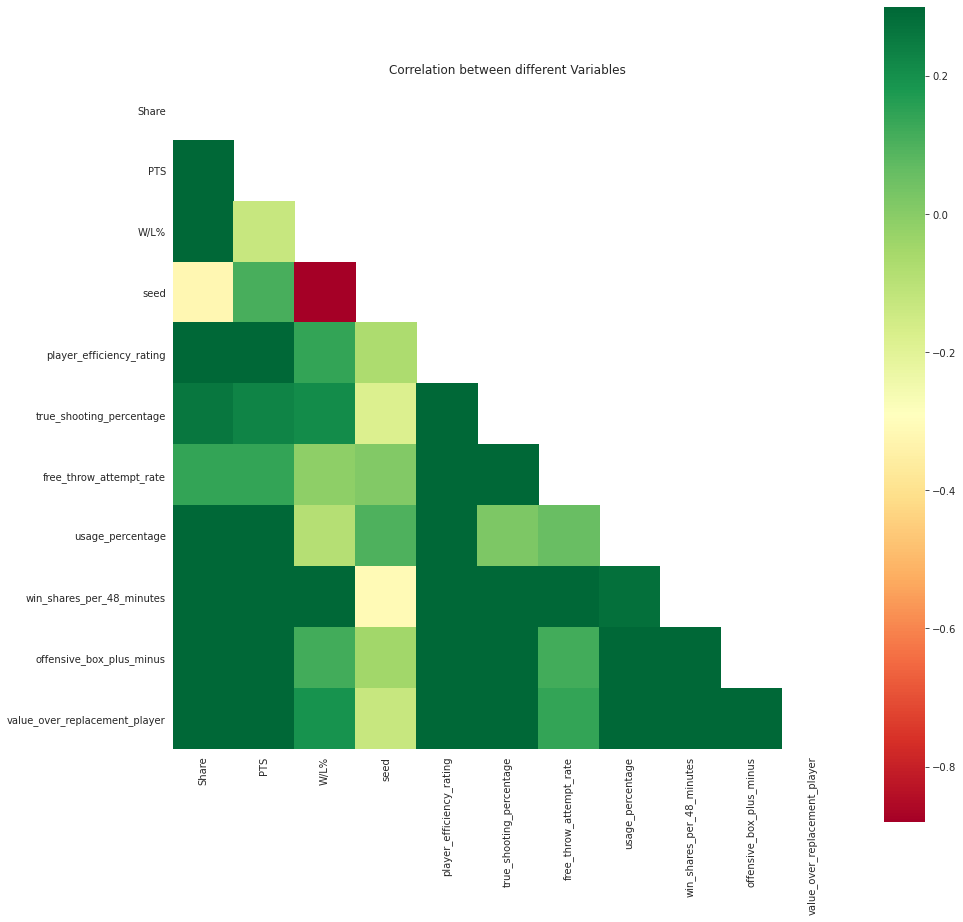

In [86]:
#Checking the correlations for each statistic
corr_matrix = master_table_mi2.corr().round(2)

#Heat map of the correlation using Seaborn package
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr_matrix, mask=mask, vmax=.3, square=True,cmap="RdYlGn")
ax.set_title("Correlation between different Variables")
plt.savefig('correlation_matrix.png', bbox_inches='tight', pad_inches=0.0)

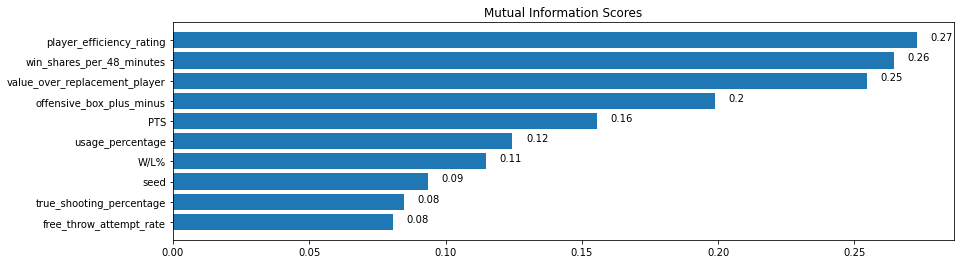

In [47]:
#Mutual information is essentially the measure of how much “knowledge” one can gain of a certain variable 
#by knowing the value of another variable. 
#Higher MI, leads to a large reduction of uncertainity. Lower MI, leads to a small reduction of uncertainity.

master_table_mi2 = master_table.copy()
master_table_mi2.drop(to_drop, axis=1, inplace=True)
X, y, mi_scores2 = calculate_ml_scores(df=master_table_mi2)
plot_mi_scores(mi_scores2, figsize=(14,4))

**Train/Test Split**

In [30]:
def train_test_split_by_year(year, df, scaling=False):
    #Test year = selected year, train year = other years outside of selected year
    train_df = df[df['year'] != year]
    test_df = df[df['year'] == year]
    
    train_df2 = train_df.copy()
    test_df2 = test_df.copy()
    
    train_df2.drop(to_drop, axis=1, inplace=True)
    test_df2.drop(to_drop, axis=1, inplace=True)
    
    #StandardScaler scales each feature/variable to unit variance
    if scaling == True:
        sc_X = StandardScaler()
        sc_y = StandardScaler()
        train_df2 = sc_X.fit_transform(train_df2)
        test_df2 = sc_y.fit_transform(test_df2)
    
    X_train = train_df2.copy()
    y_train = X_train["Share"]
    
    X_test = test_df2.copy()
    y_test = X_test["Share"]

    X_train.drop('Share', axis=1, inplace=True)
    cols = X_train.columns
    X_test.drop('Share', axis=1, inplace=True)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test, cols

In [31]:
def run_model(regressor, X_train, y_train, X_test, y_test, df, year):
    model = regressor
    model.fit(X_train, y_train) 
    predictions = model.predict(X_test)
    
    #MAE measures the average magnitude of the errors in a set of predictions, without considering their direction.
    #Chose MAE because RMSE does not describe average error alone.
    mae = mean_absolute_error(predictions, y_test)
    r2 = r2_score(y_test, predictions)
    
    mvp_race = df[df['year'] == year]
    mvp_race['predicted_share'] = predictions
    mvp_race = mvp_race.sort_values(["Share", "predicted_share"], ascending = (False, False))
                                    
    actual_winner = mvp_race[mvp_race['Share'] == mvp_race['Share'].max()]['Player']
    predicted_winner = mvp_race[mvp_race['predicted_share'] == mvp_race['predicted_share'].max()]['Player']
    return model, mae, r2, predicted_winner.iloc[0], actual_winner.iloc[0], mvp_race

In [32]:
#For Loop to repeat for each year

years = [year for year in range(1980, 2022)]

def run_model_average(df, regressor, scaling=False, print_metrics=False):
    mae_lst = []
    r2_lst = []
    predicted_lst = []
    actual_lst = []
    label_lst =[]
    model_lst = []
    for year in tqdm(years):
        X_train, y_train, X_test, y_test, cols = train_test_split_by_year(year=year, df=df, scaling=False)
        model, mae, r2, predicted_winner, actual_winner, mvp_race = run_model(regressor,
                                                             X_train,
                                                              y_train,
                                                              X_test,
                                                              y_test,
                                                              df=df,
                                                              year=year,
                                                            )
        if predicted_winner == actual_winner:
            label = 'correct'
        else:
            label = 'incorrect'
        mae_lst.append(mae)
        r2_lst.append(r2)
        predicted_lst.append(predicted_winner)
        actual_lst.append(actual_winner)
        label_lst.append(label)
        model_lst.append(model)
    d = {
    'year': years,
    'MAE': mae_lst,
    'R squared': r2_lst,
    'Predicted MVP': predicted_lst,
    'Actual MVP': actual_lst,
    'Label': label_lst
    }

    summary = pd.DataFrame(d)
    correct_count = summary['Label'].value_counts().iloc[0]
    incorrect_count = summary['Label'].value_counts().iloc[1]
    accuracy = correct_count / (correct_count + incorrect_count)
    avg_mae = summary['MAE'].mean()
    avg_r2  = summary['R squared'].mean()
    
    if print_metrics == True:
        print(f"Average MAE: {avg_mae}")
        print(f"Average R squared: {avg_r2}")
        print(f"Prediction accuracy: {accuracy}")
    return avg_mae, avg_r2, accuracy, summary, model_lst, cols

**Linear Regression MODEL**

In [49]:
lr_avg_mae, lr_avg_r2, lr_accuracy, lr_summary, lr_models, cols = run_model_average(df=master_table,
                  regressor = LinearRegression(),
                 scaling=True,
                print_metrics=True)

100%|██████████| 42/42 [00:00<00:00, 81.30it/s]

Average MAE: 0.14501732847423454
Average R squared: 0.4736940027062062
Prediction accuracy: 0.6428571428571429


In [50]:
lr_summary

,year,MAE,R squared,Predicted MVP,Actual MVP,Label
0,1980,0.139087,0.314146,Julius Erving,Kareem Abdul-Jabbar,incorrect
1,1981,0.122241,0.135301,Julius Erving,Julius Erving,correct
2,1982,0.114855,0.286219,Julius Erving,Moses Malone,incorrect
3,1983,0.120373,0.403865,Larry Bird,Moses Malone,incorrect
4,1984,0.134466,0.368492,Larry Bird,Larry Bird,correct
5,1985,0.111062,0.548133,Larry Bird,Larry Bird,correct
6,1986,0.112993,0.538663,Larry Bird,Larry Bird,correct
7,1987,0.101530,0.641945,Michael Jordan,Magic Johnson,incorrect
8,1988,0.142573,0.567924,Michael Jordan,Michael Jordan,correct
9,1989,0.104936,0.679965,Michael Jordan,Magic Johnson,incorrect


**Random Forest Regressor Model**

In [34]:
#Display features importance for the 2 tree algorithms (Random Forest & XGBoost)
def avg_feature_importance(models, cols):
    lst = []
    for model in models:
        feature_importance = list(model.feature_importances_)
        lst.append(feature_importance)
        
    df = pd.DataFrame(lst, columns=cols)
    mean_features = df.mean()
    
    #df2 = pd.DataFrame([cols ,mean_features], columns=['Feature', 'Feature Importance'])
    df2 = pd.DataFrame([cols ,mean_features]).T
    df2 = df2.rename(columns={0:'Feature', 1:'Score'}).sort_values(by='Score', ascending=False)
    
    plt.title('Feature Importance Score')
    sns.barplot(x='Score',
                y= 'Feature',
               data=df2,
                  )
    plt.show()

**Random Forest MODEL**

In [52]:
rf_avg_mae, rf_avg_r2, rf_accuracy, rf_summary, rf_models, rf_cols = run_model_average(df=master_table,
                  regressor=RandomForestRegressor(n_estimators = 23, 
                                                  random_state = 0, 
                                                  max_depth=7, 
                                                  min_samples_leaf=1,
                                                  min_samples_split=2),
                print_metrics=True)

100%|██████████| 42/42 [00:03<00:00, 12.88it/s]

Average MAE: 0.10590519618419426
Average R squared: 0.6007360707842485
Prediction accuracy: 0.6904761904761905


In [53]:
rf_summary

,year,MAE,R squared,Predicted MVP,Actual MVP,Label
0,1980,0.081898,0.428830,Julius Erving,Kareem Abdul-Jabbar,incorrect
1,1981,0.060218,0.433213,Julius Erving,Julius Erving,correct
2,1982,0.078412,0.279292,Magic Johnson,Moses Malone,incorrect
3,1983,0.079351,0.521198,Moses Malone,Moses Malone,correct
4,1984,0.091216,0.581505,Larry Bird,Larry Bird,correct
5,1985,0.054068,0.804996,Larry Bird,Larry Bird,correct
6,1986,0.075899,0.691491,Larry Bird,Larry Bird,correct
7,1987,0.072285,0.770481,Magic Johnson,Magic Johnson,correct
8,1988,0.076882,0.760383,Michael Jordan,Michael Jordan,correct
9,1989,0.062225,0.857514,Magic Johnson,Magic Johnson,correct


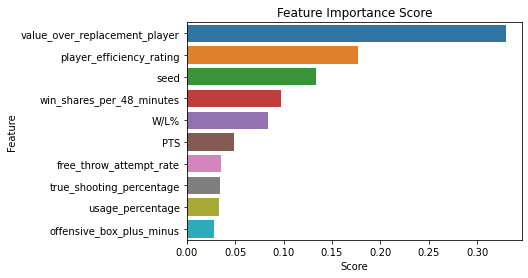

In [54]:
avg_feature_importance(models=rf_models, cols=rf_cols)

**XGBoost Model**

In [55]:
xgb_avg_mae, xgb_avg_r2, xgb_accuracy, xgb_summary, xgb_models, xgb_cols = run_model_average(df=master_table,
                  regressor = XGBRegressor(n_estimators=16, max_depth=5, learning_rate = 0.2745, subsample=1, colsample_bytree=1),
                 scaling=False, print_metrics=True)

100%|██████████| 42/42 [00:01<00:00, 24.50it/s]

Average MAE: 0.1071364674043173
Average R squared: 0.5915490467319875
Prediction accuracy: 0.7619047619047619


In [56]:
xgb_summary

,year,MAE,R squared,Predicted MVP,Actual MVP,Label
0,1980,0.068783,0.667646,Kareem Abdul-Jabbar,Kareem Abdul-Jabbar,correct
1,1981,0.056461,0.502477,Julius Erving,Julius Erving,correct
2,1982,0.084656,0.081774,Magic Johnson,Moses Malone,incorrect
3,1983,0.075484,0.532357,Moses Malone,Moses Malone,correct
4,1984,0.098589,0.461121,Larry Bird,Larry Bird,correct
5,1985,0.048276,0.873369,Larry Bird,Larry Bird,correct
6,1986,0.092135,0.722476,Larry Bird,Larry Bird,correct
7,1987,0.078742,0.681924,Magic Johnson,Magic Johnson,correct
8,1988,0.082363,0.738666,Michael Jordan,Michael Jordan,correct
9,1989,0.066769,0.811762,Magic Johnson,Magic Johnson,correct


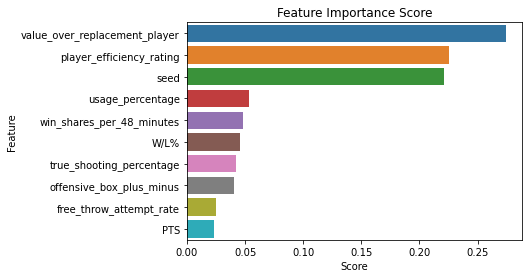

In [57]:
avg_feature_importance(models=xgb_models, cols=xgb_cols)

In [ ]:
#Images for each model's summaries

dfi.export(xgb_summary,'xgboost_summary.png')
dfi.export(rf_summary,'rf_summary.png')
dfi.export(lr_summary,'lr_summary.png')

**Model Summary Table**

In [58]:
d = {
    'Model': ['Linear Regression', 'Random Forest Regressor', 'XGBoost Regressor'],
    'average MAE': [lr_avg_mae,rf_avg_mae, xgb_avg_mae],
    'average R squared': [lr_avg_r2,rf_avg_r2, xgb_avg_r2],
    'accuracy': [lr_accuracy,rf_accuracy, xgb_accuracy],
}
model_summary_df = pd.DataFrame(d)
model_summary_df.style.highlight_max(subset = ['average R squared', 'accuracy'],
                       color = 'lightgreen', axis = 0)

,Model,average MAE,average R squared,accuracy
0,Linear Regression,0.145017,0.473694,0.642857
1,Random Forest Regressor,0.105905,0.600736,0.690476
2,XGBoost Regressor,0.107136,0.591549,0.761905


In [60]:
#all models in models list have same parameters
best_xgb_model = xgb_models[0]
best_rf_model = rf_models[0]

In [61]:
def validate_year(year):
    X_train, y_train, X_test, y_test, cols = train_test_split_by_year(year, df=master_table, scaling=False)
    model, mae, r2, predicted_winner, actual_winner, mvp_race = run_model(best_xgb_model,
                                              X_train, y_train, X_test, y_test, df=master_table, year=year)
    # shift column 'Name' to first position
    nineth_column = mvp_race.pop('predicted_share')
   
    mvp_race.insert(8, 'predicted_share', nineth_column)
    mvp_race = mvp_race.reset_index(drop=True)

    X_test_df = pd.DataFrame(columns=cols, data = X_test)
    
    print(f'Predicted: {predicted_winner}')
    print(f'Actual: {actual_winner}')
    avg_feature_importance(models=[model], cols=cols)
    
    return model, X_test_df, mvp_race #mvp_race.style.highlight_max(subset = ['Share', 'predicted_share'], color = 'lightgreen', axis = 0)

In [62]:
def visualize_shap_values(mvp_race, model):
    top_candidates = list(mvp_race.head(3)['Player'])

    for idx, player in enumerate(top_candidates):
        data_for_prediction = mvp_race[mvp_race['Player'] == player]
        data_for_prediction = data_for_prediction[list(xgb_cols)]
        data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
        rank = idx + 1
        print(f"Rank: {rank}: {player}")

        # Create object that can calculate shap values
        explainer = shap.TreeExplainer(model)
        # Calculate Shap values
        shap_values = explainer.shap_values(data_for_prediction_array)
        shap.initjs()
        display(shap.force_plot(explainer.expected_value, shap_values, data_for_prediction))

**XGBoost SHAP Visualization (Choose any year from 1980-2021)**

Predicted: Russell Westbrook
Actual: Russell Westbrook


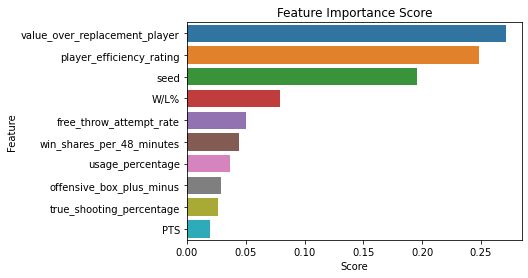

Rank: 1: Russell Westbrook


Rank: 2: James Harden


Rank: 3: Kawhi Leonard


,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,predicted_share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,year,team,W,W/L%,seed,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player
0,1,Russell Westbrook,28,OKC,69.0,888.0,1010,0.879,0.656650,81,34.6,31.6,10.7,10.4,1.6,0.4,0.425,0.343,0.845,13.1,0.224,2017,Oklahoma City Thunder,47.0,0.573,6.0,30.6,0.554,0.300,0.433,5.4,28.8,17.1,57.3,2.3,0.9,15.9,41.7,8.5,4.6,13.1,0.224,8.7,2.4,11.1,9.3
1,2,James Harden,27,HOU,22.0,753.0,1010,0.746,0.481877,81,36.4,29.1,8.1,11.2,1.5,0.5,0.440,0.347,0.847,15.0,0.245,2017,Houston Rockets,55.0,0.671,3.0,27.4,0.613,0.493,0.575,3.5,20.9,12.2,50.7,2.0,1.0,19.5,34.2,11.5,3.6,15.0,0.245,7.5,1.2,8.7,8.0
2,3,Kawhi Leonard,25,SAS,9.0,500.0,1010,0.495,0.506119,74,33.4,25.5,5.8,3.5,1.8,0.7,0.485,0.380,0.880,13.6,0.264,2017,San Antonio Spurs,61.0,0.744,2.0,27.6,0.610,0.295,0.406,3.7,15.7,9.8,18.9,2.7,1.8,9.1,31.1,8.9,4.7,13.6,0.264,7.1,2.2,9.4,7.1
3,4,LeBron James,32,CLE,1.0,333.0,1010,0.330,0.211949,74,37.8,26.4,8.6,8.7,1.2,0.6,0.548,0.363,0.674,12.9,0.221,2017,Cleveland Cavaliers,51.0,0.622,2.5,27.0,0.619,0.254,0.395,4.0,20.7,12.6,41.3,1.6,1.3,16.1,30.0,9.8,3.0,12.9,0.221,6.4,1.2,7.6,6.7
4,5,Isaiah Thomas,27,BOS,0.0,81.0,1010,0.080,0.325337,76,33.8,28.9,2.7,5.9,0.9,0.2,0.463,0.379,0.909,12.5,0.234,2017,Boston Celtics,53.0,0.646,1.0,26.5,0.625,0.439,0.441,1.9,7.0,4.4,32.5,1.4,0.4,10.7,34.0,10.9,1.6,12.5,0.234,7.8,-1.1,6.7,5.6
5,6,Stephen Curry,28,GSW,0.0,52.0,1010,0.051,0.629310,79,33.4,25.3,4.5,6.6,1.8,0.2,0.468,0.411,0.898,12.6,0.229,2017,Golden State Warriors,67.0,0.817,1.0,24.6,0.624,0.547,0.251,2.7,11.4,7.3,31.2,2.6,0.5,13.0,30.1,8.7,3.9,12.6,0.229,6.7,0.3,6.9,5.9
6,7T,John Wall,26,WAS,0.0,7.0,1010,0.007,0.261429,78,36.4,23.1,4.2,10.7,2.0,0.6,0.451,0.327,0.801,8.8,0.149,2017,Washington Wizards,49.0,0.598,4.0,23.2,0.541,0.190,0.367,2.4,10.6,6.5,46.9,2.7,1.4,16.2,30.6,5.8,3.0,8.8,0.149,4.6,0.1,4.7,4.8
7,7T,Giannis Antetokounmpo,22,MIL,0.0,7.0,1010,0.007,0.143422,80,35.6,22.9,8.8,5.4,1.6,1.9,0.521,0.272,0.770,12.4,0.210,2017,Milwaukee Bucks,42.0,0.512,6.5,26.1,0.599,0.143,0.486,5.9,22.6,14.3,26.6,2.3,4.7,13.3,28.3,7.9,4.5,12.4,0.210,4.9,2.4,7.3,6.7
8,9T,Kevin Durant,28,GSW,0.0,2.0,1010,0.002,0.443940,62,33.4,25.1,8.3,4.8,1.1,1.6,0.537,0.375,0.875,12.0,0.278,2017,Golden State Warriors,67.0,0.817,1.0,27.6,0.651,0.304,0.374,2.2,23.6,13.6,23.1,1.5,3.8,10.4,27.8,8.0,4.0,12.0,0.278,6.7,2.2,8.9,5.7
9,9T,Anthony Davis,23,NOP,0.0,2.0,1010,0.002,0.199283,75,36.1,28.0,11.8,2.1,1.3,2.2,0.505,0.299,0.802,11.0,0.195,2017,New Orleans Pelicans,34.0,0.415,10.0,27.5,0.580,0.088,0.424,6.7,27.9,17.2,11.1,1.7,5.1,9.1,32.6,5.9,5.1,11.0,0.195,4.4,1.4,5.9,5.4


In [64]:
model, X_test_df, mvp_race = validate_year(year=2017)
visualize_shap_values(mvp_race, model)
mvp_race

**Data Preparation for 2022 MVP Canidates**

In [65]:
#data to be forecasted: 2022 MVP candidates
data_2022 = pd.read_csv (r"/Users/stephenak24/Downloads/data_2022.txt")
data_2022.to_csv (r"/Users/stephenak24/Downloads/data_2022.csv", index=None)
data_2022_cleaned = data_2022.copy()
data_2022_cleaned = data_2022_cleaned[list(xgb_cols)]

In [66]:
data_2022

,Player,games_played,team,PTS,AST,STL,BLK,FG%,3P%,TRB,Tm,W,W/L%,seed,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player
0,Giannis Antetokounmpo,67,milwaukee bucks,29.880597,5.791045,1.074627,1.358209,0.553414,0.293388,11.611940,MIL,51,0.622,3,32.1,0.633,0.194,0.615,6.6,30.4,18.7,31.7,1.6,4.0,12.2,34.9,9.2,3.7,12.9,0.281,7.6,3.5,11.2,7.4
1,Joel Embiid,68,philadelphia 76ers,30.573529,4.176471,1.132353,1.455882,0.499250,0.370518,11.705882,PHI,51,0.622,4,31.2,0.616,0.188,0.602,7.2,31.1,19.4,23.5,1.7,3.9,11.3,37.2,7.9,4.1,12.0,0.252,7.2,2.0,9.2,6.5
2,Nikola Jokic,74,denver nuggets,27.081081,7.891892,1.472973,0.851351,0.582761,0.336806,13.770270,DEN,48,0.585,6,32.8,0.661,0.220,0.357,9.6,35.5,23.0,42.6,2.2,2.3,15.6,31.9,10.8,4.5,15.2,0.296,9.2,4.5,13.7,9.8


In [67]:
def prep_train_test(df):
    #train; using hitorical data from 1980 - 2021
    forecast_X_train_df = df.copy()
    forecast_X_train_df.drop(to_drop, axis=1, inplace=True)
    forecast_y_train_df = forecast_X_train_df['Share']
    forecast_X_train_df.drop(['Share'], axis=1, inplace=True)
    
    forecast_X_test_df = data_2022_cleaned
    
    print(f'Training dataset columns: \n{list(forecast_X_train_df.columns)} \n')
    print(f'Forecasting dataset columns: \n{list(forecast_X_test_df.columns)}')
    return forecast_X_train_df, forecast_y_train_df, forecast_X_test_df

In [68]:
def fit_forecast_model(regressor):
    model = regressor
    model.fit(forecast_X_train_df, forecast_y_train_df) 
    predictions = model.predict(forecast_X_test_df)
    
    mvp_race_forecast = data_2022.copy()
    mvp_race_forecast['Share Prediction'] = predictions
    mvp_race_forecast = mvp_race_forecast.sort_values(["Share Prediction"], ascending = (False))
    
    mvp_race_forecast_sub = mvp_race_forecast[[
                                                'Player',
                                                'Share Prediction',
                                                'PTS',
                                               'value_over_replacement_player',
                                               'seed',
                                                'W/L%',
                                               'player_efficiency_rating',
                                               'win_shares_per_48_minutes',
                                                'offensive_box_plus_minus',
                                                'usage_percentage', 
                                                'true_shooting_percentage',
                                            'free_throw_attempt_rate'
                                              ]].reset_index(drop=True)
    mvp_race_forecast_sub.head()
    avg_feature_importance(models=[model], cols=data_2022_cleaned.columns)
    return model, mvp_race_forecast_sub

In [69]:
def show_highlighted_df(df):
    return df.style.highlight_max(subset = ['value_over_replacement_player',
                                                    'player_efficiency_rating',
                                                    'W/L%',
                                                    'win_shares_per_48_minutes',
                                                    'usage_percentage',
                                                    'free_throw_attempt_rate',
                                                    'offensive_box_plus_minus',
                                                    'PTS',
                                                    'Share Prediction'], color = 'lightgreen', axis = 0)

In [ ]:
#train on historical data, predict on 2022 data
forecast_X_train_df, forecast_y_train_df, forecast_X_test_df = prep_train_test(df=master_table)

**XGBoost Model for 2022 MVP Canidates**

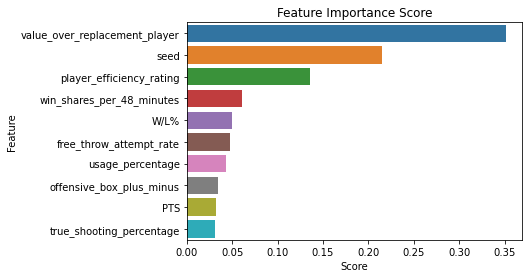

In [71]:
xgb_model, xgb_mvp_race_forecast = fit_forecast_model(regressor = XGBRegressor(
                                            n_estimators=16,
                                            max_depth=5,
                                            learning_rate=0.2745))

In [72]:
show_highlighted_df(df=xgb_mvp_race_forecast)

,Player,Share Prediction,PTS,value_over_replacement_player,seed,W/L%,player_efficiency_rating,win_shares_per_48_minutes,offensive_box_plus_minus,usage_percentage,true_shooting_percentage,free_throw_attempt_rate
0,Giannis Antetokounmpo,0.578210,29.880597,7.400000,3,0.622000,32.100000,0.281000,7.600000,34.900000,0.633000,0.615000
1,Nikola Jokic,0.557603,27.081081,9.800000,6,0.585000,32.800000,0.296000,9.200000,31.900000,0.661000,0.357000
2,Joel Embiid,0.459315,30.573529,6.500000,4,0.622000,31.200000,0.252000,7.200000,37.200000,0.616000,0.602000


In [73]:
visualize_shap_values(model= xgb_model, mvp_race=xgb_mvp_race_forecast)

Rank: 1: Giannis Antetokounmpo


Rank: 2: Nikola Jokic


Rank: 3: Joel Embiid


**Random Forest Regressor for 2022 MVP Canidates**

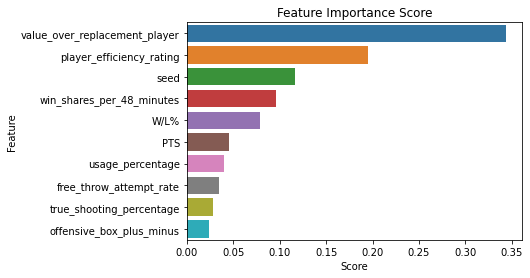

In [74]:
rf_model, rf_mvp_race_forecast = fit_forecast_model(regressor = RandomForestRegressor(n_estimators = 23, 
                                                  random_state = 0, 
                                                  max_depth=7, 
                                                  min_samples_leaf=1,
                                                  min_samples_split=2)
                                                           )

In [75]:
show_highlighted_df(df=rf_mvp_race_forecast)

,Player,Share Prediction,PTS,value_over_replacement_player,seed,W/L%,player_efficiency_rating,win_shares_per_48_minutes,offensive_box_plus_minus,usage_percentage,true_shooting_percentage,free_throw_attempt_rate
0,Nikola Jokic,0.589591,27.081081,9.800000,6,0.585000,32.800000,0.296000,9.200000,31.900000,0.661000,0.357000
1,Giannis Antetokounmpo,0.497575,29.880597,7.400000,3,0.622000,32.100000,0.281000,7.600000,34.900000,0.633000,0.615000
2,Joel Embiid,0.383880,30.573529,6.500000,4,0.622000,31.200000,0.252000,7.200000,37.200000,0.616000,0.602000


In [76]:
visualize_shap_values(model = rf_model, mvp_race= rf_mvp_race_forecast)

Rank: 1: Nikola Jokic


Rank: 2: Giannis Antetokounmpo


Rank: 3: Joel Embiid


In [77]:
forecast_tables = [xgb_mvp_race_forecast, rf_mvp_race_forecast]
model_names = ['XGBoost', 'Random Forest']

tables = []
for name, forecast_table in zip(model_names, forecast_tables):
    player_sub = forecast_table.head(3)[['Player']]
    player_sub['Rank'] = ['1st Place','2nd Place','3rd Place']
    player_sub2 = player_sub.T.reset_index(drop=True)
    player_sub2.columns = player_sub2.iloc[1]
    player_sub2.drop(player_sub2.tail(1).index,inplace=True)

    share_sub = forecast_table.head(5)[['Share Prediction']]
    share_sub['Rank'] = ['1st Place Share','2nd Place Share','3rd Place Share']
    
    share_sub2 = share_sub.T.reset_index(drop=True)
    share_sub2.columns = share_sub2.iloc[1]
    share_sub2.drop(share_sub2.tail(1).index,inplace=True)

    merged_df = pd.concat([player_sub2, share_sub2], axis=1).sort_index(axis=1)
    merged_df['Model'] = name
    tables.append(merged_df)
    
final_summary_table = pd.concat(tables)
# shift column 'Name' to first position
first_column = final_summary_table.pop('Model')
# first_column) function
final_summary_table.insert(0, 'Model', first_column)

**Prediction for 2022 MVP**

In [78]:
final_summary_table

1,Model,1st Place,1st Place Share,2nd Place,2nd Place Share,3rd Place,3rd Place Share
0,XGBoost,Giannis Antetokounmpo,0.57821,Nikola Jokic,0.557603,Joel Embiid,0.459315
0,Random Forest,Nikola Jokic,0.589591,Giannis Antetokounmpo,0.497575,Joel Embiid,0.38388
